In [1]:
# # install THIS IT READS OUT A NUMPY ARRAY
# !pip install tifffile
# !conda install -y -c conda-forge gdal
# !conda install -y -c anaconda libtiff
# !conda install -y -c conda-forge matplotlib
# !conda install -y -c conda-forge georaster
# !pip install opencv-python
# !conda install -y geopandas
# !conda install rasterio -y -c conda-forge
# !conda install imageio -y -c conda-forge
# !pip install --upgrade tensorflow
# !conda install -y -c conda-forge matplotlib
# !conda install -y -c conda-forge poppler=21.09
# !conda install -y gdal --force-reinstall
# !conda install -y pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch
# !conda install -y seaborn
# !pip install imagecodecs

# to load AIRS data  
import os
from util.transforms import tif_to_array
from scipy import ndimage
import imageio
# import tensorflow_probability as tfp 
# import tensorflow as tf
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import pyro
# import pyro.distributions as dist

# tf.debugging.set_log_device_placement(True)
# tf.config.list_physical_devices()

# To Build Basic Regression Model  
$$
P(\theta | \vec{x}) \propto P(\theta)\times P(\vec{x}|\theta)
$$
where
$$
 \begin{align}
   \vec{x} &= \begin{bmatrix}
         \text{Proximity to nearest fire pixel }d\\
         \text{Slope }s\\
         \text{Surface temperature }T\\
         \text{Days since last had fire }l
         \end{bmatrix}
  \end{align}
$$



In [2]:

DATA_DIR = '../data'
os.listdir(DATA_DIR)

['S3X_SL_1_RBT___',
 'FIRMS',
 's2',
 'lance',
 'terra_test.tif',
 'dem',
 'checksums_501650221',
 'modis',
 'S3X_SL_2_LST____',
 'airs-l3']

Format data into numpy arrays, with common indexes for common locations (i.e. 1,2 should refer to the same geographical position across all arrays)

# Baseline Data Being Used

In [3]:
# ndvi
sentinel_2_dir = os.path.join(DATA_DIR, 's2/ndvi')

# elevation map
DEM_dir = os.path.join(DATA_DIR, 'dem')

# land-surface temperature
lst_dir = os.path.join(DATA_DIR, 'modis/lstgeotiff')

## Distance to Nearest Fire-Pixel (MODIS)

In [4]:
# store file lists as file paths 
sort_file_paths = lambda prefix, dir: sorted([prefix + '/' + i for i in os.listdir(dir)])

lst_paths = sort_file_paths('../data/modis/lstgeotiff', lst_dir)

In [5]:
os.path.abspath(os.path.join(DATA_DIR, 'modis'))

'/mnt/storage/projects/fire-bot/data/modis'

In [6]:
fire_paths = ['../data/modis/' + file for file in os.listdir(os.path.join(DATA_DIR, 'modis')) if file.endswith('.npy')]
# 5-10 for dates from August
fire_distance_arr = [[file, np.load(file)] for file in fire_paths]


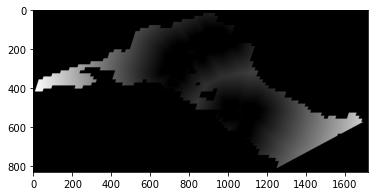

In [7]:
# sanity check
plt.imshow(fire_distance_arr[0][1], cmap='gray')

## Elevation

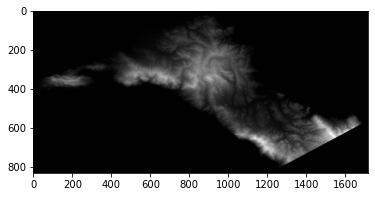

In [8]:
dem_elevation_arr = np.asarray(imageio.imread('../data/dem/DEM_elevation.tif'))

# sanity check
plt.imshow(dem_elevation_arr, cmap='gray')

## Slope

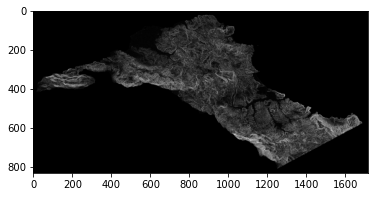

In [9]:
from scipy import ndimage
import imageio
dem_slope_arr = np.asarray(imageio.imread('../data/dem/DEM_slope.tif'))
dem_slope_arr[np.isnan(dem_slope_arr)] = 0
# sanity check
plt.imshow(dem_slope_arr, cmap='gray')

In [10]:
dem_slope_arr = np.hstack((dem_slope_arr[0:-1, :], np.zeros((829, 1))))
dem_elevation_arr =np.hstack((dem_elevation_arr[0:-1, :], np.zeros((829, 1))))

## Land-Surface Temperature (MODIS)

In [11]:


lst_arr = []

for f in range(len(lst_paths)):
    temp_file = np.asarray(tif_to_array(lst_paths[f])*0.02)
    # remove extraneous third dimension (convert to x by y without single-channel z-index)
    temp_file = temp_file.reshape(-1, temp_file.shape[-1])
    # temp_file[np.isnan(temp_file)] = np.float64(-1)
    
    file_name = lst_paths[f].split('/')[-1]
    file_name = file_name.split('.')[0]
    lst_arr.append((file_name, temp_file))
  

In [12]:
lst_arr[0][1].shape

(829, 1719)

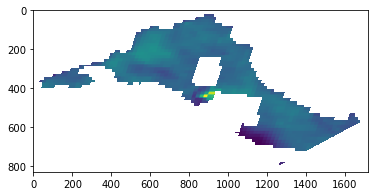

In [13]:
plt.imshow(lst_arr[0][1])

<font color="green">All base arrays loaded into numpy</font>

In [14]:
# list of arrays for reference
fire_distance_arr
lst_arr
dem_slope_arr
dem_elevation_arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
# load saved active-fire arrays
fire_active_arr = []
for file in sorted(os.listdir('../data/modis/fire_npy')):
    # flatten into single-channel since original array gives intensity 
    flat = np.max(np.load('../data/modis/fire_npy/' + file), axis=2)
    # convert to binary image, '1' for fire, '0' for no fire
    binary = np.where(flat > 0, 1, 0)
    
    fire_active_arr.append((file, binary))

In [ ]:
#list files in fire_active_arr
for filename, _ in fire_active_arr:
    print(filename)

In [17]:
# PREFER USE TERRA AS PREDICTED ALONE
# # reorder above list chronologically  
# aqua = fire_active_arr[:26]
# terra = fire_active_arr[26:]

# fire_temp = []
# # shoud be in order terra_04, aqua_04, terra_05, aqua_05, ...
# for i in range(len(aqua)):
#     fire_temp.append(terra[i])
#     fire_temp.append(aqua[i])

# # sanity-checking output order    
# for filename, file in fire_temp:
#     print(filename) 

In [18]:
for i in range(len(fire_distance_arr)):
    filename = fire_distance_arr[i][0]
    
    filename = filename.split('.')[2].split('/')[-1]   
    fire_distance_arr[i][0] = filename

In [19]:
for filename, _ in sorted(fire_distance_arr):
    print(filename)

dist_aqua_05
dist_aqua_06
dist_aqua_07
dist_aqua_08
dist_aqua_09
dist_aqua_10
dist_terra_05
dist_terra_06
dist_terra_07
dist_terra_08
dist_terra_09
dist_terra_10


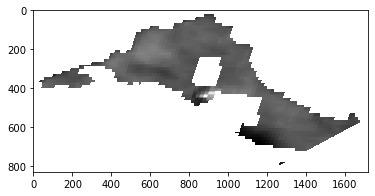

In [20]:
for filename, file in sorted(lst_arr):
    plt.imshow(file, cmap='gray')
    break
    print(filename)

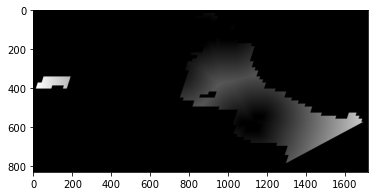

In [21]:
plt.imshow(fire_distance_arr[i][1], cmap='gray')

In [ ]:
# arrays
# use from August 5th to August 10th 
fire_distance_arr
lst_arr 
dem_elevation_arr
dem_slope_arr
fire_active_arr

In [23]:
lst_aqua = [None for _ in range(len(lst_arr[0:7]))]
lst_terra = [None for _ in range(len(lst_arr[25:32]))] 
            
lst_aqua, lst_terra = lst_arr[0:7], lst_arr[25:32]

In [24]:
for filename, file in fire_active_arr[0:7] + fire_active_arr[26:33]:
    print(filename)

fire_active_aqua, fire_active_terra = fire_active_arr[0:7], fire_active_arr[26:33]

aqua_04.npy
aqua_05.npy
aqua_06.npy
aqua_07.npy
aqua_08.npy
aqua_09.npy
aqua_10.npy
terra_04.npy
terra_05.npy
terra_06.npy
terra_07.npy
terra_08.npy
terra_09.npy
terra_10.npy


In [25]:
fire_dist_aqua = sorted(fire_distance_arr, key=lambda x: x[0])[0:6]
fire_dist_terra = sorted(fire_distance_arr, key=lambda x: x[0])[6:]

In [26]:
# # right now have
# fire_dist_terra, fire_dist_aqua
# lst_terra, lst_aqua
# fire_active_terra, fire_active_aqua

In [27]:
from numpy.random import rand

# flattening all arrays
def flatten_arr(arr):
    def _flatten_arr(arr):
        filename = arr[0]
        file = arr[1]
        return([filename, file.flatten()])
    
    return list(map(_flatten_arr, arr))

fire_dist_terra, fire_dist_aqua = flatten_arr(fire_dist_terra), flatten_arr(fire_dist_aqua)
lst_terra, lst_aqua = flatten_arr(lst_terra), flatten_arr(lst_aqua)
fire_active_terra, fire_active_aqua = flatten_arr(fire_active_terra), flatten_arr(fire_active_aqua)

In [28]:
dem_elevation_arr = dem_elevation_arr.flatten()
dem_slope_arr = dem_slope_arr.flatten()

In [29]:
# READY FOR ANALYSIS

temp = []
for file in fire_dist_terra:
    temp.append(file[1])

(array([1171462.,   42211.,   48775.,   41093.,   29078.,   27388.,
          29675.,   22545.,    9804.,    3020.]),
 array([  0.        ,  74.78215028, 149.56430055, 224.34645083,
        299.12860111, 373.91075138, 448.69290166, 523.47505194,
        598.25720221, 673.03935249, 747.82150277]),
 <BarContainer object of 10 artists>)

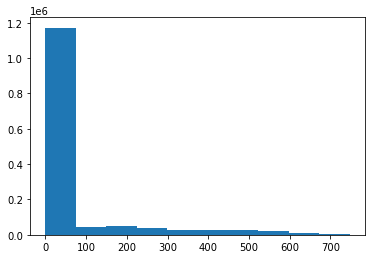

In [30]:
from matplotlib import pyplot as plt 

plt.hist(temp[5])

# Basic Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()  

# creating contiguous arrays to place into DataFrame

distance = []
for dist in fire_dist_terra:
    distance.extend(dist[1])
    
    
    
lst = []
for lst_ in lst_terra[1:]:
    lst.extend(lst_[1])

fire_active = []
for active in fire_active_terra[1:]:
    fire_active.extend(active[1])
    
    
fire_active_evening = []
for active in fire_active_aqua[1:]:
    fire_active_evening.extend(active[1])

slope = []
dem = []
for i in range(6):
    dem.extend(dem_elevation_arr)
    slope.extend(dem_slope_arr)
    
len(lst), len(fire_active)

dist_terra_05
dist_terra_06
dist_terra_07
dist_terra_08
dist_terra_09
dist_terra_10
terra_05
terra_06
terra_07
terra_08
terra_09
terra_10


(8550306, 8550306)

In [33]:
data = pd.DataFrame({
    'lst': lst,
    'fire_active': fire_active,
    'slope': slope,
    'dem': dem,
    'Y': fire_active_evening
})

In [35]:
data = data.dropna()
data.head()

,lst,fire_active,slope,dem,Y
26661,303.24,0,0.0,0.0,0
26662,303.24,0,0.0,0.0,0
26663,303.24,0,0.0,0.0,0
26664,303.24,0,0.0,0.0,0
26665,303.24,0,0.0,0.0,0


In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['lst', 'fire_active', 'slope', 'dem']], data['Y'])

In [40]:
clf.fit(X_train, y_train)

LogisticRegression()

In [42]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    426154
           1       0.81      0.31      0.45     27251

    accuracy                           0.95    453405
   macro avg       0.89      0.65      0.71    453405
weighted avg       0.95      0.95      0.94    453405

